El objetivo de esta notebook es mostrar algunas herramientas adicionales para mejorar el entrenamiento y/o desempeño de redes neuronales.

Verificar que tenemos una GPU:

In [1]:
import tensorflow as tf

print('GPU presente en: {}'.format(tf.test.gpu_device_name()))

GPU presente en: /device:GPU:0


# Callbacks: Early Stopping

Un *callback* es un objeto que puede realizar acciones en varias etapas del entrenamiento (por ejemplo, al inicio o al final de una época, antes o después de un *batch*, etc.). 

Puedes usar *callbacks* para:

* Escribir los registros de TensorBoard después de cada lote de entrenamiento para monitorizar tus métricas
* Guardar periódicamente tu modelo en el disco
* Hacer un *early stopping*.
* Obtener una visión de los estados internos y las estadísticas de un modelo durante el entrenamiento.

El `EarlyStopping` es un *callback* que nos permite detener el entrenamiento para evitar el overfitting.

Consideremos el ejemplo de entrenar una red neuronal MLP para clasificar las siguientes clases de puntos

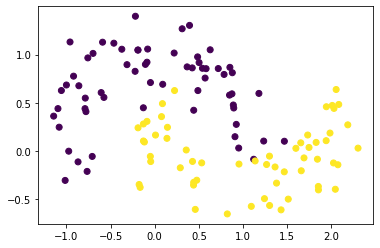

In [8]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=200, noise=0.2, random_state=1)

n_train = 120
X_train, X_val = X[:n_train, :], X[n_train:, :]
y_train, y_val = y[:n_train], y[n_train:]

plt.figure()
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.show()

Entrenamos una red neuronal. Su desempeño tendrá un accuracy de alrededor de 100% en el conjunto de entrenamiento, pero será mucho menor en el conjunto de prueba. Observa las curvas de aprendizaje.

In [9]:
from keras.models import Sequential
from keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# fit model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2000, verbose=0)

Train accuracy: 1.000. Validation accuracy : 0.962


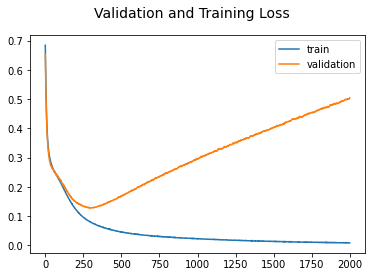

In [11]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train accuracy: %.3f. Validation accuracy : %.3f' % (train_acc, val_acc))

# plot training history
plt.figure()
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Ahora, pararemos el entrenamiento en el momento que...

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

Epoch 70: early stopping
Train accuracy: 0.908. Validation accuracy : 0.875


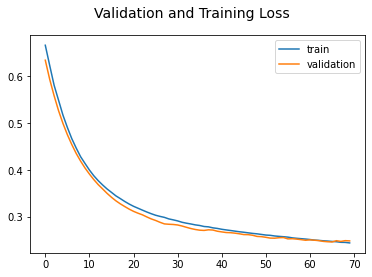

In [14]:
# fit model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2000, verbose=0, callbacks=[es])

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train accuracy: %.3f. Validation accuracy : %.3f' % (train_acc, val_acc))

# plot training history
plt.figure()
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Dropout

# Gridsearch

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# load dataset
df = pd.read_csv("diabetes.csv", delimiter=",")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
# split into input (X) and output (Y) variables
X = df.iloc[:,:8].values
Y = df.iloc[:,8].values

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(n_neurons=12,activation='sigmoid'):
	# create model
	model = Sequential()
	model.add(Dense(n_neurons, input_dim=8, activation=activation))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
neurons = [3,5,10,15,20,50,100]
activations = ['relu','sigmoid','tanh']
param_grid = dict(batch_size=batch_size, epochs=epochs,n_neurons=neurons,activation=activations)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f.3 (%f.3) with: %r" % (mean, stdev, param))

Best: 0.716146 using {'batch_size': 10, 'epochs': 100, 'n_neurons': 100}
0.604167.3 (0.065390.3) with: {'batch_size': 10, 'epochs': 10, 'n_neurons': 3}
0.566406.3 (0.084565.3) with: {'batch_size': 10, 'epochs': 10, 'n_neurons': 5}
0.621094.3 (0.022097.3) with: {'batch_size': 10, 'epochs': 10, 'n_neurons': 10}
0.639323.3 (0.036272.3) with: {'batch_size': 10, 'epochs': 10, 'n_neurons': 15}
0.632812.3 (0.052505.3) with: {'batch_size': 10, 'epochs': 10, 'n_neurons': 20}
0.632812.3 (0.006379.3) with: {'batch_size': 10, 'epochs': 10, 'n_neurons': 50}
0.635417.3 (0.043067.3) with: {'batch_size': 10, 'epochs': 10, 'n_neurons': 100}
0.649740.3 (0.020505.3) with: {'batch_size': 10, 'epochs': 50, 'n_neurons': 3}
0.664062.3 (0.014616.3) with: {'batch_size': 10, 'epochs': 50, 'n_neurons': 5}
0.687500.3 (0.022326.3) with: {'batch_size': 10, 'epochs': 50, 'n_neurons': 10}
0.683594.3 (0.019401.3) with: {'batch_size': 10, 'epochs': 50, 'n_neurons': 15}
0.662760.3 (0.013279.3) with: {'batch_size': 10, '